<a href="https://colab.research.google.com/github/cicyfan/GradientEpisodicMemory/blob/master/GEM-reproduction-and-extension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continual Learning (CL) for Robotic Perception

This project is a fork of the [Gradient Episodic Memory for Continual Learning](https://github.com/facebookresearch/GradientEpisodicMemory) Github repo. \\

Source code for [paper](https://arxiv.org/pdf/1706.08840.pdf)

```
@inproceedings{GradientEpisodicMemory,
    title={Gradient Episodic Memory for Continual Learning},
    author={Lopez-Paz, David and Ranzato, Marc'Aurelio},
    booktitle={NIPS},
    year={2017}
}
```

In this project, we will demonstrate our understanding and solution of the continual learning problem. First, we will provide our implementation of the Gradient Episodic Memory model as developed in the paper. The GEM model's architeture alleviates forgetting, and allows for beneficial transfer of knowledge to previous tasks. Second, we will take the optimal parameters as provided in the paper as a baseline, and contrast that to the performance of the model under different parameters through visualization. We will be focusing specifically on the performance on the rotated MNIST dataset. 

During our iterations of testing, we found that the GEM model achieved the best performance **(acc:89.3% bwt: 5.4% fwt: 65.2%)** when n_memories = 512 and memory_strength = 1. This was better than the baseline performance provided in the paper where n_memories = 256 and memory_strength = 0.5 (acc:84.9%, bwt: 0.3%, fwt: 66.1%).



# Environment Set up
If torch.cuda.is_available() returns False, go to Runtime -> Change Runtime Type -> Hardware Accelerator -> Select 'GPU' 

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
import subprocess
import pickle
import altair as alt
import os
import pandas as pd
from glob import glob
import datetime
import random
import uuid
import time
import math

torch.cuda.is_available()

True

Depending on the runtime, some packages may need to be installed

In [0]:
!pip install quadprog

In [0]:
import quadprog

Mount drive

In [0]:
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Clone Repo and Retrieve Data

In [0]:
!git clone https://github.com/facebookresearch/GradientEpisodicMemory.git '/content/drive/My Drive/MNIST'

fatal: destination path '/content/drive/My Drive/MNIST' already exists and is not an empty directory.


In [0]:
%cd '/content/drive/My Drive/MNIST'

/content/drive/My Drive/MNIST


In [0]:
!ls

CODE_OF_CONDUCT.md  LICENSE  model	       results
CONTRIBUTING.md     main.py  README.md	       run_experiments.sh
data		    metrics  requirements.txt


### Download data

Download and save MNIST data as **mnist_train.pt and mnist_test.pt** in /MNIST/data/raw. \\
We are omitting the CIFAR data as it's out of scope for this project. 

In [0]:
%cd '/content/drive/My Drive/MNIST/data/raw/'

/content/drive/My Drive/MNIST/data/raw


In [0]:
mnist_path = "mnist.npz"

if not os.path.exists(mnist_path):
    subprocess.call("wget https://s3.amazonaws.com/img-datasets/mnist.npz", shell=True)

f = np.load('mnist.npz')
x_tr = torch.from_numpy(f['x_train'])
y_tr = torch.from_numpy(f['y_train']).long()
x_te = torch.from_numpy(f['x_test'])
y_te = torch.from_numpy(f['y_test']).long()
f.close()

torch.save((x_tr, y_tr), 'mnist_train.pt')
torch.save((x_te, y_te), 'mnist_test.pt')

In [0]:
!ls

mnist.npz  mnist_test.pt  mnist_train.pt  raw.py


## Generate Permutated and Rotated Datasets 


In [0]:
%cd /content/drive/My Drive/MNIST/data

/content/drive/My Drive/MNIST/data


Generates **mnist_permutations.pt and mnist_rotations.pt** in /MNIST/data. \\
Each data set has 20 tasks, and each task has 1000 examples from 10 different classes.


In [0]:
!python mnist_permutations.py \
	--o mnist_permutations.pt \
	--seed 0 \
	--n_tasks 20

Rotation data is generated with a minimum rotation angle of 0 and a maximum rotation angle of 180. The data will be randomly rotated on a angle between the min and max.

In [0]:
!python mnist_rotations.py \
	--o mnist_rotations.pt\
	--seed 0 \
	--min_rot 0 \
	--max_rot 180 \
	--n_tasks 20

# Our Implementation of GEM



Load dataset

In [0]:
def load_datasets():
    d_tr, d_te = torch.load('/content/drive/My Drive/MNIST/data/mnist_rotations.pt')
    n_inputs = d_tr[0][1].size(1)
    n_outputs = 0
    for i in range(len(d_tr)):
        n_outputs = max(n_outputs, d_tr[i][2].max().item())
        n_outputs = max(n_outputs, d_te[i][2].max().item())
    return d_tr, d_te, n_inputs, n_outputs + 1, len(d_tr)

One defining feature of the Gradient Episodic Memory framework is the use of a continuum of training tasks. In this model, each pair of features and labels is also associated with some task. This is common in much of the continual learning literature, but one thing that distinguishes the GEM method is the possibility for there to be a hierarchy of tasks, with contextual information enabling success at one task to lead to improvement in other, related, tasks. As such, GEM uses a Continuum class, to express the relationship between the tasks and the data that represent them.

In [0]:
class Continuum:
    def __init__(self, data, batch_size, shuffle_tasks, samples_per_task, 
                 n_epochs):
        self.data = data
        self.batch_size = batch_size
        n_tasks = len(data)
        task_permutation = range(n_tasks)

        if shuffle_tasks == 'yes':
            task_permutation = torch.randperm(n_tasks).tolist()

        sample_permutations = []

        for t in range(n_tasks):
            N = data[t][1].size(0)
            if samples_per_task <= 0:
                n = N
            else:
                n = min(samples_per_task, N)

            p = torch.randperm(N)[0:n]
            sample_permutations.append(p)

        self.permutation = []

        for t in range(n_tasks):
            task_t = task_permutation[t]
            for _ in range(n_epochs):
                task_p = [[task_t, i] for i in sample_permutations[task_t]]
                random.shuffle(task_p)
                self.permutation += task_p

        self.length = len(self.permutation)
        self.current = 0

    def __iter__(self):
        return self

    def next(self):
        return self.__next__()

    def __next__(self):
        if self.current >= self.length:
            raise StopIteration
        else:
            ti = self.permutation[self.current][0]
            j = []
            i = 0
            while (((self.current + i) < self.length) and
                   (self.permutation[self.current + i][0] == ti) and
                   (i < self.batch_size)):
                j.append(self.permutation[self.current + i][1])
                i += 1
            self.current += i
            j = torch.LongTensor(j)
            return self.data[ti][1][j], ti, self.data[ti][2][j]

A key measure of any model for continual learning is its ability to perform well at tasks that it has not seen recently, or even (in theory) do well on tasks that it has never been trained on, if it has been trained on other, similar tasks.

In [0]:
def eval_tasks(model, tasks, cuda):
    model.eval()
    result = []
    for i, task in enumerate(tasks):
        t = i
        x = task[1]
        y = task[2]
        rt = 0
        
        eval_bs = x.size(0)

        for b_from in range(0, x.size(0), eval_bs):
            b_to = min(b_from + eval_bs, x.size(0) - 1)
            if b_from == b_to:
                xb = x[b_from].view(1, -1)
                yb = torch.LongTensor([y[b_to]]).view(1, -1)
            else:
                xb = x[b_from:b_to]
                yb = y[b_from:b_to]
            _, pb = torch.max(model(xb, t).data.cpu(), 1, keepdim=False)
            rt += (pb == yb).float().sum()

        result.append(rt / x.size(0))

    return result

def life_experience(model, continuum, x_te, log_every, cuda):
    result_a = []
    result_t = []

    current_task = 0
    time_start = time.time()

    for (i, (x, t, y)) in enumerate(continuum):
        if(((i % log_every) == 0) or (t != current_task)):
            result_a.append(eval_tasks(model, x_te, cuda))
            result_t.append(current_task)
            current_task = t

        v_x = x.view(x.size(0), -1)
        v_y = y.long()

        model.train()
        model.observe(v_x, t, v_y)

    result_a.append(eval_tasks(model, x_te, cuda))
    result_t.append(current_task)

    time_end = time.time()
    time_spent = time_end - time_start

    return torch.Tensor(result_t), torch.Tensor(result_a), time_spent

The rotated MNIST dataset is able to be handled by a rather modestly-sized neural network, with only two fully-connected hidden layers of 100 neurons each. We implement these as a multilayer perceptron, within PyTorch's existing neural network framework.

In [0]:
def Xavier(m):
    if m.__class__.__name__ == 'Linear':
        fan_in, fan_out = m.weight.data.size(1), m.weight.data.size(0)
        std = 1.0 * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        m.weight.data.uniform_(-a, a)
        m.bias.data.fill_(0.0)

class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []

        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        self.net.apply(Xavier)

    def forward(self, x):
        return self.net(x)

Previously-seen tasks have their gradients stored for future reference.

In [0]:
def store_grad(pp, grads, grad_dims, tid):
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1

If gradient vectors violate bounds, they are overridden to preserve the learning process.

In [0]:
def overwrite_grad(pp, newgrad, grad_dims):
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1

At the heart of the math behind the Gradient Episodic Memory process is a Quadratic Programming optimization problem. This is initially formulated as a primal problem, but much like with Support Vector Machines, this can be reframed as a dual problem and solved more easily that way.

In [0]:
def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))

Here we build the neural network using the tools included with PyTorch. We use standard choices for loss function (Cross Entropy) and learning method (Stochastic Gradient Descent). Much more interestingly, we also implement Episodic Memory here. Episodic Memory is probably the most important aspect of Gradient Episodic Memory, hence the name. For each task, the network stores a subset of the examples that it has seen so far. These "memories" enable the learner to continue to train on tasks that it has previously seen, and therefore prevent Catastrophic Forgetting.

In [0]:
class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_tasks, n_layers, n_hiddens,
                 memory_strength, data_file, lr, n_memories, cuda):
        super(Net, self).__init__()
        self.margin = memory_strength
        self.net = MLP([n_inputs] + [n_hiddens] * n_layers + [n_outputs])

        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs

        self.opt = optim.SGD(self.parameters(), lr)

        self.n_memories = n_memories

        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)

        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)

        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        self.nc_per_task = n_outputs

    def forward(self, x, t):
        output = self.net(x)
        return output

    def observe(self, x, t, y):
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t

        bsz = y.data.size(0)
        endcnt = min(self.mem_cnt + bsz, self.n_memories)
        effbsz = endcnt - self.mem_cnt
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                past_task = self.observed_tasks[tt]

                offset1, offset2 = 0, self.nc_per_task
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        self.zero_grad()

        offset1, offset2 = 0, self.nc_per_task
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        self.opt.step()

In [0]:
def run_model(model="gem", n_hiddens=100, n_layers=2, n_memories=256, 
              memory_strength=0, finetune=False, n_epochs=1, batch_size=10, 
              lr=0.001, cuda=False, seed=0, log_every=100, save_path="results/", 
              data_path="data/", data_file="mnist_permutations.pt", 
              samples_per_task=-1, shuffle_tasks="no"):

  # If running multiple times, will need a unique ID to keep track
  uid = uuid.uuid4().hex

  torch.backends.cudnn.enabled = False
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  x_tr, x_te, n_inputs, n_outputs, n_tasks = load_datasets()

  continuum = Continuum(x_tr, batch_size, shuffle_tasks, samples_per_task, n_epochs)
  
  model = Net(n_inputs, n_outputs, n_tasks, n_layers, n_hiddens, 
              memory_strength, data_file, lr, n_memories, cuda)

  result_t, result_a, spent_time = life_experience(model, continuum, x_te, log_every, cuda)

  if not os.path.exists(save_path):
        os.makedirs(save_path)

  fname = 'gem_' + data_file + '_'
  fname += datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
  fname += '_' + uid
  fname = os.path.join(save_path, fname)
  print(fname + ': ' + ' # ' + str(spent_time))
  torch.save((result_t, result_a, model.state_dict()), fname + '.pt')

Here we actually run the model, using the same parameters as were used in the main experiment. Two fully-connected neural networks with two hidden layers of 100 ReLU units were used. 

In [0]:
%cd /content/drive/My Drive/MNIST

run_model(model="gem", n_hiddens=100, n_layers=2, lr=0.1, n_memories=256, 
          memory_strength=0.5, data_path="data/", save_path="results/", 
          batch_size=10, log_every=100, samples_per_task=1000, 
          data_file="mnist_rotations.pt", cuda="no", seed=0)

/content/drive/My Drive/MNIST
results/gem_mnist_rotations.pt_2020_04_06_01_14_46_cd5c8499992542519487629ed086d5d3:  # 65.44673228263855


# Results and Visualization

## Replicating Paper Results
Result files are available for download [here](https://drive.google.com/drive/folders/1NGkZ-DYKcbqpt8XjqVBsfCviPVcOEgN0?usp=sharing)



In [0]:
%cd /content/drive/My Drive/MNIST/results

/content/drive/My Drive/MNIST1/results


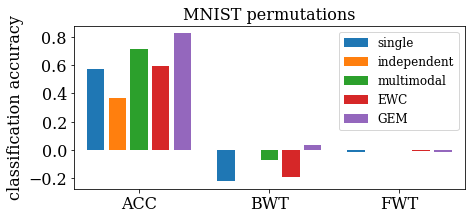

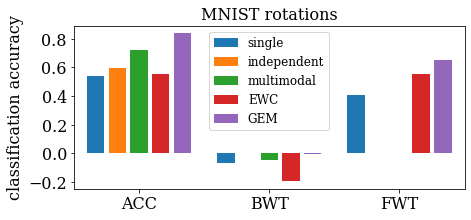

In [0]:
# Copyright 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

models = ['single', 'independent', 'multimodal', 'icarl', 'ewc', 'gem']
datasets = ['mnist_permutations', 'mnist_rotations']

names_datasets = {'mnist_permutations': 'MNIST permutations',
                  'mnist_rotations': 'MNIST rotations'}

names_models = {'single': 'single',
                'independent': 'independent',
                'multimodal': 'multimodal',
                'icarl': 'iCARL',
                'ewc': 'EWC',
                'gem': 'GEM'}

colors = {'single': 'C0',
          'independent': 'C1',
          'multimodal': 'C2',
          'icarl': 'C2',
          'ewc': 'C3',
          'gem': 'C4'}

barplot = {}

for dataset in datasets:
    barplot[dataset] = {}
    for model in models:
        barplot[dataset][model] = {}
        matches = glob(model + '*' + dataset + '*.pt')
        if len(matches):
            data = torch.load(matches[0], map_location=lambda storage, loc: storage)
            acc, bwt, fwt = data[3][:]
            barplot[dataset][model]['acc'] = acc
            barplot[dataset][model]['bwt'] = bwt
            barplot[dataset][model]['fwt'] = fwt

for dataset in datasets:
    x_lab = []
    y_acc = []
    y_bwt = []
    y_fwt = []

    for i, model in enumerate(models):
        if barplot[dataset][model] != {}:
            x_lab.append(model)
            y_acc.append(barplot[dataset][model]['acc'])
            y_bwt.append(barplot[dataset][model]['bwt'])
            y_fwt.append(barplot[dataset][model]['fwt'])

    x_ind = np.arange(len(y_acc))

    plt.figure(figsize=(7, 3))
    all_colors = []
    for xi, yi, li in zip(x_ind, y_acc, x_lab):
        plt.bar(xi, yi, label=names_models[li], color=colors[li])
        all_colors.append(colors[li])
    plt.bar(x_ind + (len(y_acc) + 1) * 1, y_bwt, color=all_colors)
    plt.bar(x_ind + (len(y_acc) + 1) * 2, y_fwt, color=all_colors)
    plt.xticks([2, 8, 14], ['ACC', 'BWT', 'FWT'], fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(-1, len(y_acc) * 3 + 2)
    plt.ylabel('classification accuracy', fontsize=16)
    plt.title(names_datasets[dataset], fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    #plt.savefig('barplot_%s.pdf' % dataset, bbox_inches='tight')
    plt.show()

The GEM model outperformed other models in terms of accuracy and maintained a high accuracy across task numbers, as well as a positive BWT (backward transfer) and the highest FWT (forward transfer).

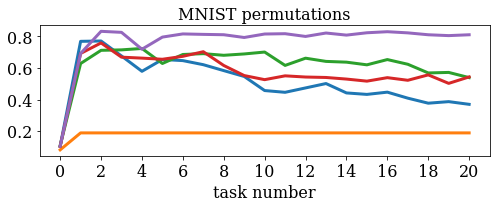

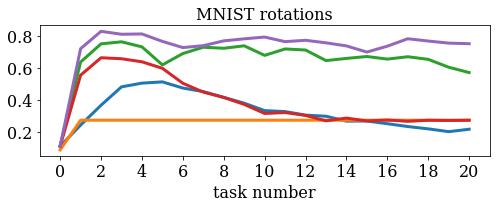

In [0]:
evoplot = {}

for dataset in datasets:
    evoplot[dataset] = {}
    for model in models:
        matches = glob(model + '*' + dataset + '*.pt')
        if len(matches):
            data = torch.load(matches[0], map_location=lambda storage, loc: storage)
            evoplot[dataset][model] = data[1][:, 0].numpy()

for dataset in datasets:

    plt.figure(figsize=(7, 3))
    for model in models:
        if model in evoplot[dataset]:
            x = np.arange(len(evoplot[dataset][model]))
            x = (x - x.min()) / (x.max() - x.min()) * 20
            plt.plot(x, evoplot[dataset][model], color=colors[model], lw=3)
            plt.xticks(range(0, 21, 2))

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('task number', fontsize=16)
    plt.title(names_datasets[dataset], fontsize=16)
    plt.tight_layout()
    #plt.savefig('evoplot_%s.pdf' % dataset, bbox_inches='tight')
    plt.show()

## Testing Different Memory Strength

Running iterations of the GEM model with 0, 0.25, 0.5, 0.75, 1 memory strength,  keeping memory size constant at n_memories = 256. 


The paper outlined that the model performed best at 0.5 memory strength; however, we found that the moel at 1 memory strength had a higher over-all accuracy (0.5: 84.9%, 1: 86%), and a higher, more positive, backward transfer (0.5: 0.3%, 1: 1.5%). The forward transfer performance was only slightly lower than 0.5 memory strength (0.5: 66.1%, 1: 65.8%). The author stated that they also tested the GEM model at 1 memory strength, it is unclear if the authors chose 0.5 memory strength as the optimal paramter for other reasons. Perhaps the 0.5 memory strength performed better for other datasets. 

**We can conclude that the GEM model performs best on the rotated MNIST dataset at 1 memory strength, holding all else equal.**

In [0]:
%cd /content/drive/My Drive/MNIST
MNIST_ROTA="--n_layers 2 --n_hiddens 100 --data_path data/ --save_path results/ --batch_size 10 --log_every 100 --samples_per_task 1000 --data_file mnist_rotations.pt    --cuda no  --seed 0"
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 256 --memory_strength 0
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 256 --memory_strength 0.25
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 256 --memory_strength 0.5 #baseline 
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 256 --memory_strength 0.75
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 256 --memory_strength 1


/content/drive/My Drive/MNIST
results/gem_mnist_rotations.pt_2020_04_05_16_12_44_780c707286a944e1890540d0756cd279: {'model': 'gem', 'n_hiddens': 100, 'n_layers': 2, 'n_memories': 256, 'memory_strength': 0.0, 'finetune': False, 'n_epochs': 1, 'batch_size': 10, 'lr': 0.1, 'cuda': False, 'seed': 0, 'log_every': 100, 'save_path': 'results/', 'data_path': 'data/', 'data_file': 'mnist_rotations.pt', 'samples_per_task': 1000, 'shuffle_tasks': 'no'} # 0.707 -0.160 0.698 # 109.67990207672119
results/gem_mnist_rotations.pt_2020_04_05_16_16_36_c858dbde880842edb338aa6fdcc83630: {'model': 'gem', 'n_hiddens': 100, 'n_layers': 2, 'n_memories': 256, 'memory_strength': 0.25, 'finetune': False, 'n_epochs': 1, 'batch_size': 10, 'lr': 0.1, 'cuda': False, 'seed': 0, 'log_every': 100, 'save_path': 'results/', 'data_path': 'data/', 'data_file': 'mnist_rotations.pt', 'samples_per_task': 1000, 'shuffle_tasks': 'no'} # 0.831 -0.014 0.663 # 107.97500252723694
results/gem_mnist_rotations.pt_2020_04_05_16_20_28_70

In [0]:
%cd /content/drive/My Drive/MNIST/Results
ms_0 = "gem_mnist_rotations.pt_2020_04_05_16_12_44_780c707286a944e1890540d0756cd279"
ms_25 = "gem_mnist_rotations.pt_2020_04_05_16_16_36_c858dbde880842edb338aa6fdcc83630"
ms_5 = "gem_mnist_rotations.pt_2020_04_05_16_20_28_70477d862a9847898109d83f6fa51440"
ms_75 = "gem_mnist_rotations.pt_2020_04_05_16_24_17_966c0abcb4d1475aa1a72c3debd4242f"
ms_100 = "gem_mnist_rotations.pt_2020_04_05_16_28_06_b74827924bce46b8925951f2b179aaa0"
rota_ms = [ms_0, ms_25, ms_5, ms_75, ms_100]

In [0]:
stats = []
for i, ms in enumerate(rota_ms): 
  data= torch.load(ms+".pt")
  stats.append(data)

### Evolution of Accuracy Across 20 Tasks
Similar to how it was done in the paper, I am graphing the evolution of the test
accuracy at the first task

In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][1][:, 0].numpy())

In [0]:
source = pd.DataFrame({
  'task': np.linspace(0, 20, num=21), 
  '0%': acc[0],
  '25%': acc[1],
  '50%': acc[2],
  '75%': acc[3],
  '100%': acc[4]
}).melt('task', var_name='memory strength', value_name='accuracy')

In [0]:
alt.Chart(source).mark_line().encode(
    x='task:O',
    y='accuracy:Q',
    color=alt.Color('memory strength:N', sort=['0%', '25%'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Accuracy Across Memory Strength

In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][0].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '0%': acc[0],
  '25%': acc[1],
  '50%': acc[2],
  '75%': acc[3],
  '100%': acc[4]
}, index=[0]).melt(var_name='memory strength', value_name='accuracy')

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory strength:N',sort=['0%', '25%']),
    y='accuracy:Q',
    color=alt.Color('memory strength:N', sort=['0%', '25%'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Backward Transfer Across Memory Strength


Catastrophic forgetting is observed where backward transfer is negative.


In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][1].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '0%': acc[0],
  '25%': acc[1],
  '50%': acc[2],
  '75%': acc[3],
  '100%': acc[4]
}, index=[0]).melt(var_name='memory strength', value_name='backward transfer')

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory strength:N',sort=['0%', '25%']),
    y='backward transfer:Q',
    color=alt.Color('memory strength:N', sort=['0%', '25%'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Forward Transfer Across Memory Strength


In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][2].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '0%': acc[0],
  '25%': acc[1],
  '50%': acc[2],
  '75%': acc[3],
  '100%': acc[4]
}, index=[0]).melt(var_name='memory strength', value_name='forward transfer') 

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory strength:N',sort=['0%', '25%']),
    y='forward transfer:Q',
    color=alt.Color('memory strength:N', sort=['0%', '25%'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

## Testing Different Memory Size

Running iterations of the GEM model with n_memories = 256, 512, 1024, 2048, 4096, 8192, and 16384, keeing memory strength constant at 0.5. Bigger is not always better in this case, as the performance metrics peaks when n_memories = 2048, and decreases as n_memories grows further

In [0]:
%cd /content/drive/My Drive/MNIST
MNIST_ROTA="--n_layers 2 --n_hiddens 100 --data_path data/ --save_path results/ --batch_size 10 --log_every 100 --samples_per_task 1000 --data_file mnist_rotations.pt    --cuda no  --seed 0"
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 256 --memory_strength 0.5 #baseline
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 512 --memory_strength 0.5
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 1024 --memory_strength 0.5
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 2048 --memory_strength 0.5
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 4096 --memory_strength 0.5
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 8192 --memory_strength 0.5
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 16384 --memory_strength 0.5

/content/drive/My Drive/MNIST
results/gem_mnist_rotations.pt_2020_04_05_20_45_13_c90ade3f6139454f88da072ebf687ba4: {'model': 'gem', 'n_hiddens': 100, 'n_layers': 2, 'n_memories': 16384, 'memory_strength': 0.5, 'finetune': False, 'n_epochs': 1, 'batch_size': 10, 'lr': 0.1, 'cuda': False, 'seed': 0, 'log_every': 100, 'save_path': 'results/', 'data_path': 'data/', 'data_file': 'mnist_rotations.pt', 'samples_per_task': 1000, 'shuffle_tasks': 'no'} # 0.796 -0.067 0.691 # 1660.8125381469727


In [0]:
%cd /content/drive/My Drive/MNIST/results
m_256 = "gem_mnist_rotations.pt_2020_04_05_19_21_28_60780a5451804fcd82e00d74c153ba8c"
m_512 = "gem_mnist_rotations.pt_2020_04_05_19_25_58_e59d4433221447a7a437ef322549079a"
m_1024 = "gem_mnist_rotations.pt_2020_04_05_19_31_25_bcd75879da00404cbc87ef0468a0803b"
m_2048 = "gem_mnist_rotations.pt_2020_04_05_19_38_37_4634db9ce0c445379d87c9fccbcb5d8c"
m_4096 = "gem_mnist_rotations.pt_2020_04_05_19_48_59_74059717ef2241a4a25a035a0fd9a4d8"
m_8192 = "gem_mnist_rotations.pt_2020_04_05_20_13_37_4e3620748bab4a9db304d90bbde74108"
m_16384 = "gem_mnist_rotations.pt_2020_04_05_20_45_13_c90ade3f6139454f88da072ebf687ba4"
rota_m = [m_256, m_512, m_1024, m_2048, m_4096, m_8192, m_16384]

/content/drive/My Drive/MNIST/results


In [0]:
stats = []
for i, m in enumerate(rota_m): 
  data= torch.load(m+".pt")
  stats.append(data)

### Evolution of Accuracy Across 20 Tasks
Similar to how it was done in the paper, I am graphing the evolution of the test
accuracy at the first task.

In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][1][:, 0].numpy())

In [0]:
source = pd.DataFrame({
  'task': np.linspace(0, 20, num=21), 
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}).melt('task', var_name='memory size', value_name='accuracy')

In [0]:
alt.Chart(source).mark_line().encode(
    x='task:O',
    y='accuracy:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Accuracy Across Memory Size

In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][0].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}, index=[0]).melt(var_name='memory size', value_name='accuracy')

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory size:N',  sort=['256','512']),
    y='accuracy:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Backward Transfer Across Memory Size


In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][1].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}, index=[0]).melt(var_name='memory size', value_name='backward transfer')

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory size:N', sort=['256','512']),
    y='backward transfer:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Forward Transfer Across Memory Size


In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][2].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}, index=[0]).melt(var_name='memory size', value_name='forward transfer') 

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory size:N', sort=['256','512']),
    y='forward transfer:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

## Testing Different Memory Size with Optimal Memory Strength

Running iterations of the GEM model with n_memories = 256, 512, 1024, 2048, 4096, 8192, and 16384 with memory strength of 1. Here we found the optimal parameters to be n_memories = 512 and memory_strength = 1.

In [0]:
%cd /content/drive/My Drive/MNIST
MNIST_ROTA="--n_layers 2 --n_hiddens 100 --data_path data/ --save_path results/ --batch_size 10 --log_every 100 --samples_per_task 1000 --data_file mnist_rotations.pt    --cuda no  --seed 0"
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 256 --memory_strength 1 #baseline
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 512 --memory_strength 1
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 1024 --memory_strength 1
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 2048 --memory_strength 1
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 4096 --memory_strength 1
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 8192 --memory_strength 1
!python main.py $MNIST_ROTA --model gem --lr 0.1 --n_memories 16384 --memory_strength 1

/content/drive/My Drive/MNIST
results/gem_mnist_rotations.pt_2020_04_05_23_26_44_63d72106ca2b48b5a1e36f0c568f4ec5: {'model': 'gem', 'n_hiddens': 100, 'n_layers': 2, 'n_memories': 256, 'memory_strength': 1.0, 'finetune': False, 'n_epochs': 1, 'batch_size': 10, 'lr': 0.1, 'cuda': False, 'seed': 0, 'log_every': 100, 'save_path': 'results/', 'data_path': 'data/', 'data_file': 'mnist_rotations.pt', 'samples_per_task': 1000, 'shuffle_tasks': 'no'} # 0.860 0.015 0.658 # 108.87254524230957
results/gem_mnist_rotations.pt_2020_04_05_23_30_57_64f4866c57144e839113a0a44fa06e69: {'model': 'gem', 'n_hiddens': 100, 'n_layers': 2, 'n_memories': 512, 'memory_strength': 1.0, 'finetune': False, 'n_epochs': 1, 'batch_size': 10, 'lr': 0.1, 'cuda': False, 'seed': 0, 'log_every': 100, 'save_path': 'results/', 'data_path': 'data/', 'data_file': 'mnist_rotations.pt', 'samples_per_task': 1000, 'shuffle_tasks': 'no'} # 0.893 0.054 0.652 # 128.88874316215515
results/gem_mnist_rotations.pt_2020_04_05_23_36_02_6518b

In [0]:
%cd /content/drive/My Drive/MNIST/results
m_256 = "gem_mnist_rotations.pt_2020_04_05_23_26_44_63d72106ca2b48b5a1e36f0c568f4ec5"
m_512 = "gem_mnist_rotations.pt_2020_04_05_23_30_57_64f4866c57144e839113a0a44fa06e69"
m_1024 = "gem_mnist_rotations.pt_2020_04_05_23_36_02_6518b2356f914887a654dd57227b616a"
m_2048 = "gem_mnist_rotations.pt_2020_04_05_19_38_37_4634db9ce0c445379d87c9fccbcb5d8c"
m_4096 = "gem_mnist_rotations.pt_2020_04_05_23_42_39_be51ba961cff4fb987b8edf1860dc78b"
m_8192 = "gem_mnist_rotations.pt_2020_04_05_23_51_53_17a6bea3272d40d88bb5e915c23cb31c"
m_16384 = "gem_mnist_rotations.pt_2020_04_06_00_06_28_15fa52eafd474558b78f84e265fc5033"
rota_m = [m_256, m_512, m_1024, m_2048, m_4096, m_8192, m_16384]

/content/drive/My Drive/MNIST/results


In [0]:
stats = []
for i, m in enumerate(rota_m): 
  data= torch.load(m+".pt")
  stats.append(data)

### Evolution of Accuracy Across 20 Tasks


In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][1][:, 0].numpy())

In [0]:
source = pd.DataFrame({
  'task': np.linspace(0, 20, num=21), 
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}).melt('task', var_name='memory size', value_name='accuracy')

In [0]:
alt.Chart(source).mark_line().encode(
    x='task:O',
    y='accuracy:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Accuracy Across Memory Size

In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][0].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}, index=[0]).melt(var_name='memory size', value_name='accuracy')

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory size:N',  sort=['256','512']),
    y='accuracy:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Backward Transfer Across Memory Size


In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][1].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}, index=[0]).melt(var_name='memory size', value_name='backward transfer')

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory size:N', sort=['256','512']),
    y='backward transfer:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)

### Forward Transfer Across Memory Size


In [0]:
acc = []
for i in range(len(stats)):
  acc.append(stats[i][3][2].cpu().numpy())

In [0]:
source = pd.DataFrame({
  '256': acc[0],
  '512': acc[1],
  '1024': acc[2],
  '2048': acc[3],
  '4096': acc[4], 
  '8192': acc[5],
  '16384': acc[6]
}, index=[0]).melt(var_name='memory size', value_name='forward transfer') 

In [0]:
alt.Chart(source).mark_bar().encode(
    x=alt.X('memory size:N', sort=['256','512']),
    y='forward transfer:Q',
    color=alt.Color('memory size:N', sort=['256','512'])
).properties(
    width=600,
    height=300
).interactive()

alt.Chart(...)